# Restaurant Recommendation System  

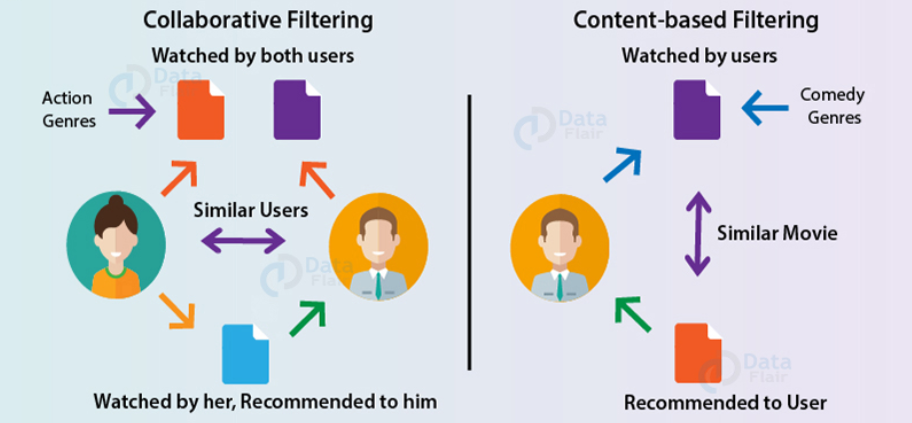 

Image Source: DataFlair recommendation system blog


### Content Based Filtering Method   
A content-based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on those recommendations, the engine becomes more and more accurate.  


### Generating recommendations based on cosine similarity of review texts  
  
  
https://www.kaggle.com/yelp-dataset/yelp-dataset  

The dataset has been downloaded from Kaggle and contains the reviews of customers on Yelp website.  
It contains different categories data like Electronics, Home Theatre Installation, Shopping, Home Services, Restaurants and much more for 8 different Metro cities of US and Canada.  
For this project, I focussed on Restaurant categories of Massachussets.  
  
### *Research Question* :  
1. What are the top similar restaurants based on the reviews given by  a user ?  
2. Recommend top restaurants based on a specific keyword like, 'Thai', 'Mexican' or 'pizza', 'sandwich' etc.  

In [1]:
# Import libraries
import numpy as np

from operator import add
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover, VectorAssembler
from pyspark.ml.feature import IDF
from pyspark.ml import Pipeline, PipelineModel


from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Creating instance of Spark Sessions
sc = SparkContext()
spark = SparkSession.builder.appName('FinalProject').getOrCreate()

# Get sparkcontext from 
sqlContext = SQLContext(sc)

In [3]:
# Read data 
df_business = spark.read.json('Large_Yelp_datasets/yelp_academic_dataset_business.json')
df_reviews  = spark.read.json('Large_Yelp_datasets/yelp_academic_dataset_review.json')
df_users  = spark.read.json('Large_Yelp_datasets/yelp_academic_dataset_user.json')

In [4]:
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
# Filter business data for Restaurant category and MA state
df_business_MA = df_business.select('business_id', 'name',  'address', 'city', \
                                      'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories') \
                                .filter( (df_business.state == 'MA') & (df_business.categories.contains('Restaurants') ) )

business_count = df_business_MA.count()
print(f'MA Business count: {business_count}')

# Sampling data to run on local
sampled_business_MA = df_business_MA.sample(0.1, 123)

sampled_business_count = sampled_business_MA.count()
print(f'Sampled Business count: {sampled_business_count}')

df_business_MA.printSchema()

MA Business count: 10550
Sampled Business count: 1071
root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- categories: string (nullable = true)



In [6]:
# Extract reviews of restaurants in MA
# Here we will extract only those reviews for which restaurant Ids are same as that we extracted in above step
df_reviews_MA = df_reviews.join(sampled_business_MA, on = 'business_id', how = 'inner') \
                          .select(df_reviews.business_id, df_reviews.user_id, df_reviews.review_id, df_reviews.stars, df_reviews.text)
df_reviews_MA.show(2)

df_reviews_count = df_reviews_MA.count()
print(f'Business Reviews count: {df_reviews_count}')

+--------------------+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|           review_id|stars|                text|
+--------------------+--------------------+--------------------+-----+--------------------+
|EEHhKSxUvJkoPSzeG...|99RsBrARhhx60UnAC...|KKVFopqzcVfcubIBx...|  5.0|I work in the Pru...|
|vV5ciKb5sDKVmF8mA...|-ZWB-76_QEkrJ13gz...|rHWmye_VbL5Vbxi8T...|  1.0|I just had a terr...|
+--------------------+--------------------+--------------------+-----+--------------------+
only showing top 2 rows

Business Reviews count: 141954


In [7]:
# Extract MA user data
# Similary, filter all those users who have given reviews or ratings to restaurants extracted in above step.
df_users_MA = df_users.join(df_reviews_MA, on = 'user_id', how = 'inner') \
                          .select(df_users.user_id, df_users.name, df_users.review_count, df_users.yelping_since, \
                                  df_users.useful, df_users.funny , df_users.cool , df_users.fans , df_users.average_stars)
df_users_MA.show(2)

df_users_MA_count = df_users_MA.count()
print(f'Business Reviews count: {df_users_MA_count}')


+--------------------+---------+------------+-------------------+------+-----+----+----+-------------+
|             user_id|     name|review_count|      yelping_since|useful|funny|cool|fans|average_stars|
+--------------------+---------+------------+-------------------+------+-----+----+----+-------------+
|-EGNVqKxvmAfY3-mO...|  Michael|           1|2017-06-17 11:48:41|     1|    0|   0|   0|          5.0|
|-RxneMk47ybso11n8...|Christina|           5|2011-07-21 04:16:41|     3|    0|   0|   1|          4.8|
+--------------------+---------+------------+-------------------+------+-----+----+----+-------------+
only showing top 2 rows

Business Reviews count: 141954


In [8]:
# Store smaller datasets for further use

sampled_business_MA.coalesce(1).write.parquet('Small_Datasets/small_business')
df_reviews_MA.coalesce(1).write.parquet('Small_Datasets/small_reviews')
df_users_MA.coalesce(1).write.parquet('Small_Datasets/small_users')

# Load the sampled data 

In [9]:
# Read data generated from above process
business_df = spark.read.parquet('Small_Datasets/small_business')
business_count = business_df.count()

reviews_df = spark.read.parquet('Small_Datasets/small_reviews')
reviews_count = reviews_df.count()

users_df = spark.read.parquet('Small_Datasets/small_users')
users_count = users_df.count()

print(f'Business COunt: {business_count}')
print(f'Reviews COunt: {reviews_count}')
print(f'Users COunt: {users_count}')

Business COunt: 1071
Reviews COunt: 141954
Users COunt: 141954


# Text Processing  
1. We will first consolidate all the reviews of a particular business Id.  
2. Next, will convert those reviews into words and generate a TF-IDF vector out of that.  
3. We will be using a dictionary of 1000 words only for our analysis.  

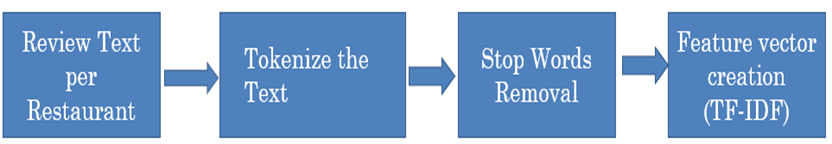


In [10]:
# Create review text df from reviews data
reviews_text = reviews_df.select('business_id', 'text')
reviews_text.show(3)

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|EEHhKSxUvJkoPSzeG...|I work in the Pru...|
|vV5ciKb5sDKVmF8mA...|I just had a terr...|
|C--wIpxJ4j1y01G_r...|Wow. Thank you, Y...|
+--------------------+--------------------+
only showing top 3 rows



In [11]:
# Group all reviews per business
from operator import add

reviews_by_business = reviews_text.rdd.map(tuple).reduceByKey(add)
columns = ['business_id', 'text']
reviews_by_business_df = spark.createDataFrame(reviews_by_business, schema = columns)
reviews_by_business_df.show(3)

# count should be the total number of business
reviews_by_business_df.count()

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|G4enu8vxbQk4h_2Cd...|Went to the Regga...|
|yKvlRknp1Feues1rG...|We went here on H...|
|tPY0JQVfAVEvVeDau...|We couldn't wait,...|
+--------------------+--------------------+
only showing top 3 rows



1071

### Pipeline to convert texts into tokens and then to TF-IDF vector

In [12]:
# Now, we will do the text processing
# Remove the stop words from text, and create the tf idf matrix 
# Will build a pipeline for this task

tokenizer        = RegexTokenizer(pattern = '\w+', inputCol = 'text', outputCol = 'tokens', toLowercase=True, gaps = False)
stopWordsRemover = StopWordsRemover(inputCol = 'tokens', outputCol = 'nostopwords')
countVectorizer  = CountVectorizer(inputCol='nostopwords', outputCol='tf', vocabSize=1000)
tfiDF            = IDF(inputCol='tf', outputCol='tfidf_vec')
pipeline         = Pipeline(stages=[tokenizer, stopWordsRemover, countVectorizer, tfiDF])


# Fit the model
pipeline_model = pipeline.fit(reviews_by_business_df)

# save the pipeline model
pipeline_model.write().overwrite().save('pipeline_model')

In [13]:
# Load the pipeline model
pipeline_model = PipelineModel.load('pipeline_model')

In [14]:
# convert the review data into feature vectors
transformed_reviews_by_business = pipeline_model.transform(reviews_by_business_df)

In [15]:
transformed_reviews_by_business.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- tfidf_vec: vector (nullable = true)



# Cosine Similarity Based on Review Text of different restaurants

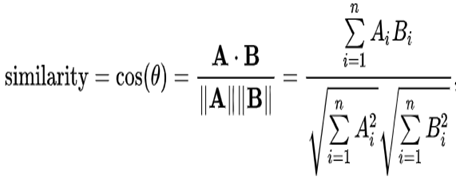

In [16]:
def cosineSimilarity(vector1, vector2):
    '''
    Function to compute cosine similarity between 2 vectors
    -------------------------------------------------------
    Input: 
        Vector-1: Each restaurants feature vector 
        Vector-2: myRestaurant Feature vector 
                  for which recommendations to be made
    
    Returns: A similarity score (between 0 and 1)
    '''
        
    #  sum(A . B) / (sqrt(sum (A**2)  * sqrt(sum (B**2)))
    numerator = np.dot(vector1, vector2)
    denominator = np.sqrt(np.dot(vector1, vector1)) * np.sqrt(np.dot(vector2, vector2))
    
    return float(numerator/denominator)

In [17]:
def getUserRecommendations(restaurant_ids, all_business_tfidf) :
    '''
    Function to recommend restaurants based on
    cosine similarity score between user reviewed restaurant and others.
    ----------------------------------------------------------------
    Input:  IDs of max 5 restaurants for which recoemmendation is needed
    Return: A dataframe with 5 recommendations for each of user reviews restaurants. 

    '''
    
    # Creating a dataframe to merge results of different input restaurant ids
    schema = StructType([   
                            StructField("business_id", StringType(), True)
                            ,StructField("similarity_score", IntegerType(), True)
                        ])

    similar_restuarants_final = spark.createDataFrame([], schema)


    for rest_id in user_restaurants:

        # Collecting feature values i.e. review texts for user rated restaurants
        user_restaurant_features = all_business_tfidf.map(lambda x: x[1] if x[0] == rest_id else None) \
                                                               .filter(lambda x: x != None).collect()[0]

        # Computing similarity between user rated restaurants and other restaurants reviews
        similar_restaurants_rdd = all_business_tfidf.map(lambda x: (x[0], cosineSimilarity(x[1], user_restaurant_features)))

        # Convert the results into df
        similar_restaurants_df = similar_restaurants_rdd.toDF(schema = ['business_id', 'similarity_score'])

        # Filter out those restaurants from this which are already been rated by our user
        similar_restaurants_df = similar_restaurants_df.filter(similar_restaurants_df.business_id != rest_id)

        similar_restaurants_df = similar_restaurants_df.orderBy('similarity_score', ascending=False).limit(5)


        similar_restuarants_final = similar_restuarants_final.union(similar_restaurants_df)

    # Data might contain duplicate restaurant ids, so removing those
    similar_restuarants_final.dropDuplicates(['business_id']).orderBy('similarity_score', ascending=False).limit(10)
    
    return similar_restuarants_final

In [18]:
def getRestaurantDetails(sim_rest):
    '''
    Function to get the recommended restaurant details based on ids.
    ---------------------------------------------------------------
    Returns -> Name of restaurant
               Category of restaurant
               Rating
               Similarity score with input restaurant id
               Total review count given to that restaurant
    '''
    
    restaurant_details = sim_rest.join(business_df, on='business_id', how = 'inner') \
                                 .select(sim_rest.business_id, \
                                       sim_rest.similarity_score, business_df.name, \
                                       business_df.categories, business_df.stars, business_df.review_count,
                                       business_df.latitude, business_df.longitude)
    
    return restaurant_details

# Making Recommendations

### 1. Top Restaurants recommended to a User based on his past reviews 

In [21]:
# Selecting a random user 
from pyspark.sql.functions import rand
usr_id = reviews_df.select('user_id').orderBy(rand()).limit(1).collect()
my_user = [val.user_id for val in usr_id][0]

#my_user = '6FvrfCqKu59ItrYM8BF8qg'

# Now, we will make User profile based on the reviews he has given in the past  
# Selecting all those restaurants that user has rated with more than 2 ratings 
# and limiting to just 2 reviewed restaurants
user_reviews = reviews_df.filter( (reviews_df.user_id == my_user) & (reviews_df.stars > float(2.0)) )\
                        .select(reviews_df.business_id).distinct().limit(2)

user_restaurants = [val.business_id for val in user_reviews.collect()]

user_rest_details = user_reviews.join(business_df, on='business_id', how = 'inner')

print(f'\nRestaurants previously reviewed by user: {my_user}')
user_rest_details.select('business_id', 'name', 'categories', 'stars').orderBy('stars', ascending=False).show()

'''
Now, for making the recommendations
We will first fetch the feature values for all the restaurant ids 
and then find the similarity of our user's rated restaurants feature values with the rest ones 
'''

# Fetch all business word vectors -> (business_id => [reviews word vectors] ) 
all_business_tfidf = transformed_reviews_by_business.select('business_id', 'tfidf_vec') \
                                                    .rdd.map(lambda x: (x[0], x[1]))

# Get recommendations for user based on his reviews ones
similar_restuarants = getUserRecommendations(user_restaurants, all_business_tfidf)


# Get restaurant details for our similar df like name, categories, ratings and review count    
similar_restuarants_details = getRestaurantDetails(similar_restuarants)


print(f'\nRestaurants recommended for User: {my_user}')
similar_restuarants_details.drop('latitude', 'longitude') \
                           .orderBy('similarity_score', ascending=False).show(10)



Restaurants previously reviewed by user: t903_es-gp3abvdrIQutQA
+--------------------+---------+--------------------+-----+
|         business_id|     name|          categories|stars|
+--------------------+---------+--------------------+-----+
|1hWZ0K2DOKZB9Xft0...|Sorellina|French, Bars, Gre...|  4.0|
|L0Ds6wNdgS0YwqVNW...|   Saloon|American (Traditi...|  3.5|
+--------------------+---------+--------------------+-----+


Restaurants recommended for User: t903_es-gp3abvdrIQutQA
+--------------------+------------------+--------------------+--------------------+-----+------------+
|         business_id|  similarity_score|                name|          categories|stars|review_count|
+--------------------+------------------+--------------------+--------------------+-----+------------+
|rcn3L8ZeQebdG0K1R...|0.8579636449925377|               Drink|American (New), B...|  4.0|        1572|
|mTyK9-_6CYY6XYAG5...|0.8480090355424806|Carrie Nation Coc...|Nightlife, Restau...|  3.5|         345|
|

### 2. Top-10 Recommendations based on a Specific Keyword  
  
If a user wants some recommendations based on a specific keyword, like a particular type of restaurant, or recommendations based on a specific food item.  


In [22]:
def keyWordsRecommendation(keyword, all_business_tfidf):
    
    input_word_df = sc.parallelize([(0, keyword)]).toDF(['business_id', 'text'])
    
    # For getting recommendation based on a keywords, first we need to transform it 
    # into word vector. So, we will load our pipelined model that we saved earlier
    input_word_df = pipeline_model.transform(input_word_df)
    
    # Get word2vectors data for this keyword
    input_word_tfidf = input_word_df.select('tfidf_vec').collect()[0][0]
    
    # Get similarity
    similar_restaurants_rdd = all_business_tfidf.map(lambda x: (x[0], cosineSimilarity(x[1], input_word_tfidf)))
    
    sim_rest_by_keyword = similar_restaurants_rdd.toDF(['business_id', 'similarity_score']) \
                                             .orderBy('similarity_score', ascending=False).limit(10)
    
    
    return sim_rest_by_keyword
    

In [23]:
# Key word similarity in review text for recommendation
key_word = 'Indian'

print(f'\nRestaurants similar to keyword - {key_word}')
sim_business_keyword = keyWordsRecommendation(key_word, all_business_tfidf)

# Get details of these similar restaurants
sim_business_keyword_details = getRestaurantDetails(sim_business_keyword)
sim_business_keyword_details.cache()
sim_business_keyword_details.drop('input_business_id', 'latitude', 'longitude').orderBy('stars', ascending=False).show()


Restaurants similar to keyword - Indian
+--------------------+------------------+--------------------+--------------------+-----+------------+
|         business_id|  similarity_score|                name|          categories|stars|review_count|
+--------------------+------------------+--------------------+--------------------+-----+------------+
|Q-_5cf30RqSxqD-_r...|0.9201489876174676|    Guru The Caterer|Seafood, Indian, ...|  4.5|         438|
|R3hizKMBF97jLUn-Y...|0.8795243811508001|Zaika Taste of India| Indian, Restaurants|  4.5|          80|
|7WFFKd32_9UxZ7ShT...|0.8706482665704621|         Dosa Temple|Vegetarian, Resta...|  4.0|          60|
|l0lE5IHVzsNmc4j5d...|0.8454120822826324|    House Of Tandoor|Restaurants, Indi...|  4.0|          60|
|BW-DVTVCF3jao9K-c...|0.8120035617931189|       Pronti Bistro|Indian, Restauran...|  4.0|         139|
|ZA6kZBzb0qZtWf1T0...|0.8204021834558428|Ghazal Fine India...|Pakistani, Restau...|  3.5|         209|
|b6AVkVXllteg7-U04...|0.89468928

# Visualizing Results on MA map  
Using Folium Map library from Python to display these recommendations of keyword.  
Each Pop-up will show the name of restaurant as well it's rating and total review count.  

In [24]:
# pip install folium
import folium

MA_coordinates = [42.4072, -71.3824]

restaurant_map = folium.Map(location = MA_coordinates, zoom_start = 12) 

# Converting spark dataframe to Pandas df for plotting
keyword_df = sim_business_keyword_details \
                                    .select('name', 'stars', 'review_count', 'latitude', 'longitude').toPandas()

# add marker one by one on the map
for i in range(0,len(keyword_df)):
    folium.Marker(
                  location=[keyword_df.iloc[i]['latitude'], keyword_df.iloc[i]['longitude']],
                  popup=keyword_df.iloc[i]['name'] + '\n' + \
                        'Rating: ' + str(keyword_df.iloc[i]['stars']) + '\n' + \
                        'Reviews: ' + str(keyword_df.iloc[i]['review_count']), \
                  icon=folium.Icon(color='green')
                  ).add_to(restaurant_map)

# Show the map again
restaurant_map

### Limitations of this approach:  
1. If a user is only interested in Items let's say B, C, D then the system will not be able to recommend them items apart from these categories which they might like as well.  
2. Another problem with this approach is that the model can make recommendations based on existing interests of users and it is quite common that not every user provide ratings or reviews to a product/item, where this method fails to provide recommendations due to lack of user profile.  
 